In [5]:
import os 
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Read data

In [20]:
def read_ml_small():
    data_dir = './ml-100k/ratings.csv'
    data = pd.read_csv(data_dir)
    num_users = data.userId.unique().shape[0]
    num_items = data.movieId.unique().shape[0]
    
    return data, num_users, num_items

# Statistics of the Dataset

In [21]:
data, num_users, num_items = read_ml_small()
sparsity = 1 - len(data) / (num_users * num_items) # 데이터에서 rating이 빈 것의 비율(행렬 만들었을 때)

print(f'유저수 : {num_users}') 
print(f'영화수 : {num_items}')
print(f'matrix sparsity : {sparsity}')
print(data.sample(5))

유저수 : 610
영화수 : 9724
matrix sparsity : 0.9830003169443864
       userId  movieId  rating   timestamp
91447     593     2355     2.5  1181008115
52493     342     2706     4.0  1042821871
9852       64     6296     4.0  1161563806
37895     256   134130     4.5  1446579780
75796     477     5291     4.5  1200939343


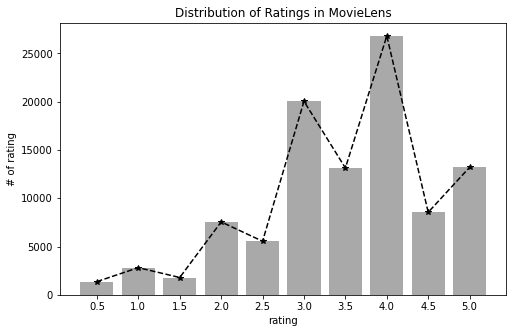

In [22]:
# count rating barchart
rating_cnt = data.rating.value_counts().sort_index()

fig, ax = plt.subplots(1,1, figsize = (8,5))

ax.plot(rating_cnt, 
       color = 'black',
       marker = '*',
       linestyle = '--')
ax.bar(rating_cnt.index, rating_cnt, 
       color = 'darkgray',
       width = 0.4)

ax.set_title('Distribution of Ratings in MovieLens')
ax.set_xlabel('rating')
ax.set_ylabel('# of rating')
ax.set_xticks(rating_cnt.index)
plt.show()

# Label Encoding

In [24]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['userId'].values)
data['item_id_idx'] = item_le.fit_transform(data['movieId'].values)

# mu

In [25]:
mu = torch.tensor(data['rating'].mean())
mu

tensor(3.5016)

# set Dataset

In [49]:
from torch.utils.data import Dataset

class MovielensDataset(Dataset):
    """MovieLens dataset"""
    
    def __init__(self,data, train = False, test_ratio = 0.1):
        self.data = data
        self.train = train
        self.test_ratio = test_ratio
        
        # split data
        self.train_data, self.test_data = self.split_train_test_data(self.data,test_ratio)
        
        # train/test confirmed
        if self.train == False:
            self.data = self.train_data
        else:
            self.data = self.test_data
            
        # set user, item, rating    
        self.users = torch.tensor(self.data['user_id_idx'].values) 
        self.items = torch.tensor(self.data['item_id_idx'].values)
        self.ratings = torch.tensor(self.data['rating'].values) 
    

    def split_train_test_data(self, data, test_ratio = 0.1):
        """
        train_test_split(data test_size train_size, stratify = self.df['user_id_idx'].values)로 대체 가능
        stratify -> Label별 sampling 
        """
        user_id_uniq = self.data.userId.unique()
        mask = []
        for i in user_id_uniq:
            data_user = self.data[self.data['userId'] == i]
            mask.extend([True if x==1 else False for x in np.random.uniform(0,1,len(data_user))<1-test_ratio])
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
        return train_data, test_data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        users = self.users[idx]
        items = self.items[idx]
        ratings = self.ratings[idx]
        return (users, items, ratings.float())
        

# Model (MF)

In [103]:
from torch import nn
from torch.nn import Module

class MF(Module):
    """MF"""
    
    def __init__(self, num_factors, num_users, num_items, mu):
        super(MF,self).__init__()
        # set latent matrix shape
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        
        # set bias shape
        self.user_bias = nn.Embedding(num_users,  1)
        self.item_bias = nn.Embedding(num_items,  1)
        
        self.mu = mu
        
    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        mu = self.mu
        outputs = torch.sum((P_u*Q_i),axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu
        
        return outputs.flatten()

# Train & evaluation function

In [97]:
def train(model, trian_iter, loss, optm, device):
    model.train()
    loss_sum = 0
    
    for users, items, ratings in trian_iter:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)
        
        preds = model(users, items)
        loss_out = loss(preds, ratings)
        
        # update
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        
        loss_sum += loss_out.item()
    
    loss_avg = loss_sum/len(trian_iter)
    
    return loss_avg

In [98]:
def evaluate(model, test_iter, device):    
    with torch.no_grad():
        model.eval()
        loss = nn.MSELoss()
        loss_sum = 0
        
        for idx, (users,items,ratings) in enumerate(test_iter):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            preds = model(users, items)
            
            loss_out = loss(preds, ratings)
            
            loss_sum += loss_out.item()

    loss_avg = loss_sum / len(test_iter)
    
    return loss_avg

# Let's go

In [109]:
# 파라미터 설정

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # device 설정

num_factors = 30 # Latent factor 수
batch_size = 128 # 배치사이즈
epochs = 31 # 에포크 수
lr = 0.01 # 학습률

device

device(type='cpu')

In [110]:
from torch.utils.data import DataLoader

# train/test data 불러오기 by Dataset&Dataloader
train_dataset = MovielensDataset(data = data, train = True)
test_dataset = MovielensDataset(data = data, train = False)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [111]:
# 모델 객체 생성 
model = MF(num_factors, num_users, num_items, mu).to(device)
loss = nn.MSELoss() # loss 객체
optm = torch.optim.Adam(model.parameters(), lr = lr) # optimizer 객체

epoch: 0, train Loss: 29.6071, test Loss: 25.9087
epoch: 5, train Loss: 1.3046, test Loss: 18.2497
epoch: 10, train Loss: 0.2987, test Loss: 17.5976
epoch: 15, train Loss: 0.2645, test Loss: 17.1890
epoch: 20, train Loss: 0.2949, test Loss: 16.6662
epoch: 25, train Loss: 0.3526, test Loss: 15.9398
epoch: 30, train Loss: 0.4153, test Loss: 15.0477


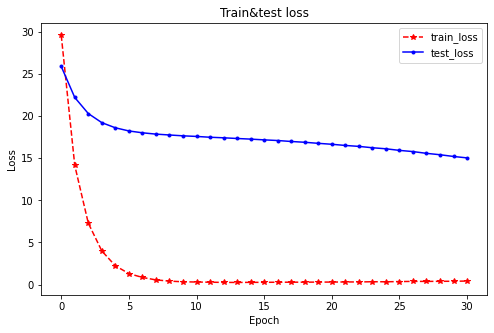

In [112]:
# 학습
train_losses = []
test_losses = []

for epoch in range(epochs):

    train_loss = train(model, train_loader, loss, optm, device)
    test_loss = evaluate(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if epoch%5==0:
        print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

# 그래프
fig, ax = plt.subplots(1,1, figsize = (8,5))

ax.plot(train_losses, label = 'train_loss',
       color = 'red',
       marker = '*',
       linestyle = '--')
ax.plot(test_losses, label = 'test_loss',
       color = 'blue',
       marker = '.')

ax.set_title('Train&test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()